In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import os
from tqdm import tqdm
from scipy.stats import chi2_contingency
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.sparse import csr_array
from sklearn import preprocessing 

In [2]:
# set directory
os.chdir('/Users/karol/Desktop/Antwerp/ai_project')
# data paths
articles_path = "data/articles.csv"
customers_path = "data/customers.csv"
submission_path = "data/sample_submission.csv"
transactions_path = "data/transactions_train.csv"

# datasets
articles = pd.read_csv(articles_path)
customers = pd.read_csv(customers_path)
submission = pd.read_csv(submission_path)
transactions = pd.read_csv(transactions_path)

# Feature engineering - Article dataset

## Feature preprocessing

It was decided to remove coded columns and encode all atributes by myself to integers.

In [3]:
articles.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [4]:
sel_articles = articles[['article_id'] + list(articles.select_dtypes(include=['object']).columns)]
sel_articles = sel_articles.drop(columns=["detail_desc","index_code"])

article_encodings = {}
for column in sel_articles.columns.drop("article_id"):
    names = sel_articles[column].unique()
    encoders = np.arange(len(names))
    article_encodings[column] = dict(zip(names, encoders))
    sel_articles[column] = sel_articles[column].apply(lambda x: article_encodings[column][x])

In [5]:
sel_articles.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int64
 1   prod_name                     105542 non-null  int64
 2   product_type_name             105542 non-null  int64
 3   product_group_name            105542 non-null  int64
 4   graphical_appearance_name     105542 non-null  int64
 5   colour_group_name             105542 non-null  int64
 6   perceived_colour_value_name   105542 non-null  int64
 7   perceived_colour_master_name  105542 non-null  int64
 8   department_name               105542 non-null  int64
 9   index_name                    105542 non-null  int64
 10  index_group_name              105542 non-null  int64
 11  section_name                  105542 non-null  int64
 12  garment_group_name            105542 non-null  int64
dtypes: int64(13)
m

The encoding process reduced memory usage from 117.6 MB to only 11.3 MB. Now I used label encoding however during training I might use one hot encoding. Then we obtain sparse matrix.

## Feature generation

### Quarter of peak sales per article

In [6]:
# Create quarter variable
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions["quarter"] = transactions["t_dat"].dt.quarter
#  Check which quarter of the year an article is sold most popularly
quarter_transactions = pd.DataFrame(transactions.groupby(["article_id", "quarter"])["quarter"].count().unstack().idxmax(axis=1), columns=["quarter_of_peak_sales"])
sel_articles = sel_articles.merge(quarter_transactions, on="article_id")

# Additional variable season 
# def season(x):
#     if x in np.arange(3,6):
#         return 0
#     elif x in np.arange(6,9):
#         return 1
#     if x in np.arange(9,12):
#         return 2
#     else:
#         return 3
transactions["month"] = transactions["t_dat"].dt.month   
transactions["year"] = transactions["t_dat"].dt.year   
# transactions["season"] = transactions["month"].apply(season)

## Feature Selection

There are many variables which are grouped. Consequently, we have some redundant variables which may bring noise to our data. Therefore, it was decided to drop some of them. Firstly, it was decided to drop product name they are grouped to product types. It is believed that that product names are too specific and provide too much noise. However, it is also believed that product group name which groups product types is too broad. All information that product group consist are provided by product type. Similar approach was applied for colours. It was decided to drop Colour Group and Perceived Colour Value names then leave Perceived Colour Master name.
For indices it was decided to leave index name and drop index group name.

In [7]:
cols_to_delete = ["prod_name","product_group_name","colour_group_name","perceived_colour_value_name","perceived_colour_value_name","index_group_name"]
sel_articles = sel_articles.drop(columns=cols_to_delete)

# Feature engineering - Customer dataset

## Feature preprocessing

As for FN and Active variable we have only values 1.0 it was decided to to fill NAs with -1. Similarly for club member status and for fashion news frequency however they also were encoded to reduce memory. For age it was decided to fill it with median score.

In [8]:
customers.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

In [9]:
customers.FN = customers.FN.fillna(-1)
customers.Active = customers.Active.fillna(-1)
age_median = np.median(customers["age"].dropna())
customers.age = customers.age.fillna(age_median)

In [10]:
customer_cols = ["club_member_status","fashion_news_frequency","postal_code"]
customers = customers.fillna(-1)
customer_encodings = {}
for column in customers[customer_cols]:
    names = customers[column].unique()
    if -1 in names:
        names = names[names != -1]
        encoders = np.arange(len(names))
        customer_encodings[column] = dict(zip(names, encoders))
        customer_encodings[column][-1] = -1
    else:
        encoders = np.arange(len(names))
        customer_encodings[column] = dict(zip(names, encoders))
    
    customers[column] = customers[column].apply(lambda x: customer_encodings[column][x])

## Feature generation

In [11]:
# Encode customer_id in transactions dataset
# transactions["customer_id"] = transactions["customer_id"].apply(lambda x: customer_encodings["customer_id"][x])
# Merge transactions and sel_articles datasets
merged = transactions.merge(sel_articles[["article_id","product_type_name","index_name","garment_group_name"]], on="article_id")

### Customers clusters based on their product types they bought

In [12]:
# Get customers baskets
customer_baskets = merged.groupby("customer_id")["product_type_name"].unique()

# Create a list of unique product_type_name values across all customers
all_unique_products = np.unique(merged["product_type_name"])

# Create a numpy matrix to store the basket data
matrix = np.zeros((len(customer_baskets), np.max(all_unique_products)+1), dtype=int)

# Populate the matrix with 1s for each customer's products
for i, basket in enumerate(customer_baskets):
    matrix[i, basket] = 1

# Get sparse matrix
matrix_sparse = csr_array(matrix)

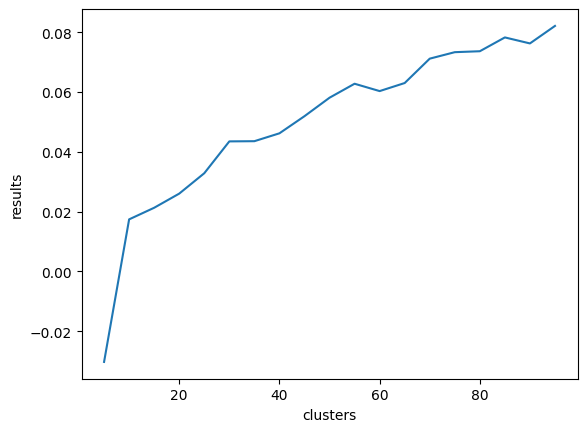

In [ ]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
matrix_sparse_norm = csr_array(matrix)

# Dictionary to store silhouette scores
silhouette_results_norm = {"clusters": [], "results": []}

# Get sample
num_rows_to_select = np.floor(0.01*len(matrix_norm)).astype("int")
num_rows = matrix_norm.shape[0]
random_indices = np.random.choice(num_rows, size=num_rows_to_select, replace=False)
random_matrix_sparse = matrix_sparse_norm[random_indices]
random_matrix = matrix_norm[random_indices]
# Generating scores
for n_cluster in np.arange(5,100,5):
    kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
    y = kmeans.fit_predict(random_matrix)
    res = silhouette_score(random_matrix_sparse, y)
    silhouette_results_norm["clusters"].append(n_cluster)
    silhouette_results_norm["results"].append(res)

        
    
sns.lineplot(data=silhouette_results_norm, x="clusters", y="results")
plt.show()

In [13]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
# Set final number of clusters
n_cluster = 10
# Create kmeans class and predict clusters for customers
kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
product_type_cluster = kmeans.fit_predict(matrix_norm)
product_type_cluster = pd.DataFrame(zip(customer_baskets.keys(), product_type_cluster), columns=["customer_id","product_type_cluster"])
# Merge dataframes
customers = customers.merge(product_type_cluster, on="customer_id", how="inner")
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,product_type_cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.0,-1.0,0,0,49.0,0,4
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1.0,-1.0,0,0,25.0,1,5
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.0,-1.0,0,0,24.0,2,5
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1.0,-1.0,0,0,54.0,3,9
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,7


### Customers clusters based on their index group names

In [14]:
# Get customers baskets
customer_baskets = merged.groupby("customer_id")["index_name"].unique()

# Create a list of unique product_type_name values across all customers
all_unique_products = np.unique(merged["index_name"])

# Create a numpy matrix to store the basket data
matrix = np.zeros((len(customer_baskets), np.max(all_unique_products)+1), dtype=int)

# Populate the matrix with 1s for each customer's products
for i, basket in enumerate(customer_baskets):
    matrix[i, basket] = 1

# Get sparse matrix
matrix_sparse = csr_array(matrix)

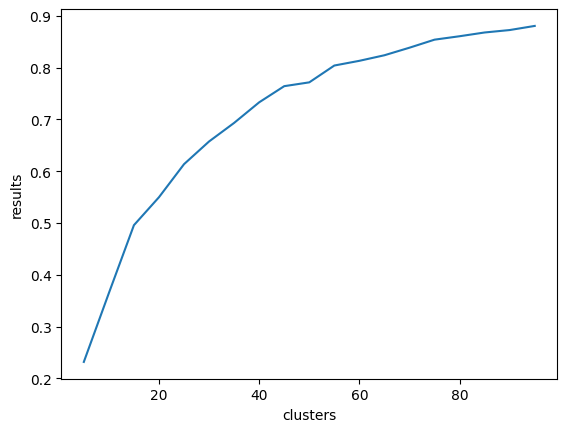

In [49]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
matrix_sparse_norm = csr_array(matrix)

# Dictionary to store silhouette scores
silhouette_results_norm = {"clusters": [], "results": []}

# Get sample
num_rows_to_select = np.floor(0.01*len(matrix_norm)).astype("int")
num_rows = matrix_norm.shape[0]
random_indices = np.random.choice(num_rows, size=num_rows_to_select, replace=False)
random_matrix_sparse = matrix_sparse_norm[random_indices]
random_matrix = matrix_norm[random_indices]
# Generating scores
for n_cluster in np.arange(5,100,5):
    kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
    y = kmeans.fit_predict(random_matrix)
    res = silhouette_score(random_matrix_sparse, y)
    silhouette_results_norm["clusters"].append(n_cluster)
    silhouette_results_norm["results"].append(res)

sns.lineplot(data=silhouette_results_norm, x="clusters", y="results")
plt.show()

In [15]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
# Set final number of clusters
n_cluster = 10
# Create kmeans class and predict clusters for customers
kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
index_name_cluster = kmeans.fit_predict(matrix_norm)
index_name_cluster = pd.DataFrame(zip(customer_baskets.keys(), index_name_cluster), columns=["customer_id","index_name_cluster"])
# Merge dataframes
customers = customers.merge(index_name_cluster, on="customer_id", how="inner")
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,product_type_cluster,index_name_cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.0,-1.0,0,0,49.0,0,4,3
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1.0,-1.0,0,0,25.0,1,5,5
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.0,-1.0,0,0,24.0,2,5,5
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1.0,-1.0,0,0,54.0,3,9,5
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,7,4


### Customers clusters based on their garment group names

In [16]:
customer_baskets = merged.groupby("customer_id")["garment_group_name"].unique()

# Create a list of unique product_type_name values across all customers
all_unique_products = np.unique(merged["garment_group_name"])

# Create a numpy matrix to store the basket data
matrix = np.zeros((len(customer_baskets), np.max(all_unique_products)+1), dtype=int)

# Populate the matrix with 1s for each customer's products
for i, basket in enumerate(customer_baskets):
    matrix[i, basket] = 1

# Get sparse matrix
matrix_sparse = csr_array(matrix)

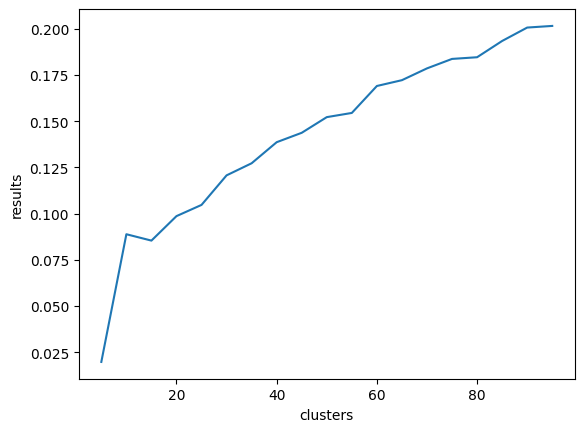

In [51]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
matrix_sparse_norm = csr_array(matrix)

# Dictionary to store silhouette scores
silhouette_results_norm = {"clusters": [], "results": []}

# Get sample
num_rows_to_select = np.floor(0.01*len(matrix_norm)).astype("int")
num_rows = matrix_norm.shape[0]
random_indices = np.random.choice(num_rows, size=num_rows_to_select, replace=False)
random_matrix_sparse = matrix_sparse_norm[random_indices]
random_matrix = matrix_norm[random_indices]
# Generating scores
for n_cluster in np.arange(5,100,5):
    kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
    y = kmeans.fit_predict(random_matrix)
    res = silhouette_score(random_matrix_sparse, y)
    silhouette_results_norm["clusters"].append(n_cluster)
    silhouette_results_norm["results"].append(res)

        
    
sns.lineplot(data=silhouette_results_norm, x="clusters", y="results")
plt.show()

In [17]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
# Set final number of clusters
n_cluster = 30
# Create kmeans class and predict clusters for customers
kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
garment_cluster = kmeans.fit_predict(matrix_norm)
garment_cluster = pd.DataFrame(zip(customer_baskets.keys(), garment_cluster), columns=["customer_id","garment_cluster"])
# Merge dataframes
customers = customers.merge(garment_cluster, on="customer_id", how="inner")
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,product_type_cluster,index_name_cluster,garment_cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.0,-1.0,0,0,49.0,0,4,3,15
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1.0,-1.0,0,0,25.0,1,5,5,22
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.0,-1.0,0,0,24.0,2,5,5,24
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1.0,-1.0,0,0,54.0,3,9,5,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,7,4,24


### Categorize age variable

In [18]:
age_bins = [16, 25, 40, 55, 100]
age_labels = [0, 1, 2, 3]
customers["age_group"] = pd.cut(customers.age, bins=age_bins, labels=age_labels, right=False)
customers[["age", "age_group"]]

,age,age_group
0,49.0,2
1,25.0,1
2,24.0,0
3,54.0,2
4,52.0,2
...,...,...
1362276,24.0,0
1362277,21.0,0
1362278,21.0,0
1362279,18.0,0


### Sales channel preference by customer

In [19]:
# Function to assign channel preferences
def channel_preference_func(x):
    if (x==1).all():
        # First channel
        return 1
    elif (x==2).all():
        # Second channel
        return 2
    else:
        # Both channels preference
        return 0

# Applies function to find prefernces
channel_preferences = transactions[["customer_id","sales_channel_id"]].groupby('customer_id')['sales_channel_id'].apply(channel_preference_func).reset_index()
customers = customers.merge(channel_preferences, on="customer_id", how="inner")
customers = customers.rename(columns={"sales_channel_id":"preferred_sales_channel"})
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,product_type_cluster,index_name_cluster,garment_cluster,age_group,preferred_sales_channel
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.0,-1.0,0,0,49.0,0,4,3,15,2,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1.0,-1.0,0,0,25.0,1,5,5,22,1,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.0,-1.0,0,0,24.0,2,5,5,24,0,2
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1.0,-1.0,0,0,54.0,3,9,5,2,2,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,7,4,24,2,0


## Feature selection

In the customers datasets it was decided to drop only age column as new one, age group, was created. It is belived that categorized age might provide more valuable information with less noise.

In [20]:
customers = customers.drop(columns="age")

# Feature engineering - Transactions

## Feature preprocessing

Here the only feature that required encoding was customer id. However, it was handled in the previous sections. Additionally, in this dataset we don't have ay NA values therefore no preprocessing is required. 

In [21]:
transactions.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
quarter             0
month               0
year                0
dtype: int64

In [22]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,quarter,month,year
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,9,2018
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,3,9,2018
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,3,9,2018
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,3,9,2018
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,3,9,2018


## Feature generation

One feature that could be generated is quarter of the year. However, it was already created in the previous section.

### Average price

In [23]:
avg_price = pd.DataFrame(transactions.groupby("customer_id")["price"].mean().rename("avg_price"), columns=["avg_price"])
transactions = transactions.merge(avg_price, on="customer_id", how="inner")
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,quarter,month,year,avg_price
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,9,2018,0.039154
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,3,9,2018,0.039154
2,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,9,2018,0.039154
3,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,578020002,0.013542,2,1,3,2019,0.039154
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,723529001,0.025407,2,1,2,2020,0.039154


### Price group

In [24]:
price_bins = [np.min(transactions.price), np.quantile(transactions.price, 0.25),
            np.quantile(transactions.price, 0.75), np.max(transactions.price)]
price_labels = [0, 1, 2]
transactions["price_group"] = pd.cut(transactions.price, bins=price_bins, labels=price_labels, right=False)
transactions[["price", "price_group"]]

,price,price_group
0,0.050831,2
1,0.030492,1
2,0.050831,2
3,0.013542,0
4,0.025407,1
...,...,...
31788319,0.050831,2
31788320,0.050831,2
31788321,0.042356,2
31788322,0.033881,2


### Age group and Index name interaction

In [25]:
# Merge datasets
merged = transactions.merge(customers, on="customer_id", how="inner")
merged = merged.merge(sel_articles, on="article_id", how="inner")
merged.head()

,t_dat,customer_id,article_id,price,sales_channel_id,quarter,month,year,avg_price,price_group,...,age_group,preferred_sales_channel,product_type_name,graphical_appearance_name,perceived_colour_master_name,department_name,index_name,section_name,garment_group_name,quarter_of_peak_sales
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,9,2018,0.039154,2,...,0,2,64,0,0,45,1,1,1,4
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,9,2018,0.039154,2,...,0,2,64,0,0,45,1,1,1,4
2,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,2,4,11,2018,0.028023,2,...,1,0,64,0,0,45,1,1,1,4
3,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,2,4,11,2018,0.028023,2,...,1,0,64,0,0,45,1,1,1,4
4,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,3,9,2018,0.039232,2,...,1,0,64,0,0,45,1,1,1,4


In [26]:
# Get uniqe age group and index name values
age_unique = merged["age_group"].unique()
index_name_unique = merged["index_name"].unique()
# Create dictionary to encode interaction
interaction_encoder = {(i,j):0 for i in range(len(age_unique)) for j in range(len(index_name_unique))}
indx = 0
for key in list(interaction_encoder.keys()):
    interaction_encoder[key] = indx
    indx += 1
# Get interactions from dataset
merged["age_index_interaction"] = list(zip(merged.age_group, merged.index_name))
# Apply encoder
merged["age_index_interaction"] = merged["age_index_interaction"].apply(lambda x: interaction_encoder[x])
merged["age_index_interaction"].head()
transactions["age_index_interaction"] = merged["age_index_interaction"] 

### Rank articles monthly

In [28]:
grouped_counts = transactions.groupby(["year","month","article_id"])["article_id"].count()
articles_rank = grouped_counts.groupby(["year", "month"]).rank(ascending=False)
articles_rank = articles_rank.rename("top_articles")
articles_rank

year  month  article_id
2018  9      108775015        27.0
             108775044       227.0
             108775051      2348.5
             110065001      1948.0
             110065002      5052.5
                            ...   
2020  9      952267001      4184.5
             952938001     10295.5
             953450001      7273.0
             953763001      4513.5
             956217002      6353.0
Name: top_articles, Length: 768883, dtype: float64

In [29]:
transactions = transactions.merge(articles_rank, how="left", on=["article_id","year","month"])

### Rank customers monthly

In [30]:
grouped_counts = transactions.groupby(["year","month","customer_id"])["customer_id"].count()
customers_rank = grouped_counts.groupby(["year", "month"]).rank(ascending=False)
customers_rank = customers_rank.rename("top_customers")
customers_rank

year  month  customer_id                                                     
2018  9      0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa     17803.5
             000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318     67371.5
             00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2      1244.5
             0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c9199e53dbb81641becd7    123272.0
             00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d60c6d7be26f06264d6    123272.0
                                                                                   ...   
2020  9      fffd0248a95c2e49fee876ff93598e2e20839e51b9b7678aab75d9e8f9f3c6c8     38477.5
             fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd0eb40a3065971d0e01    124566.0
             fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20e02ce5d1e58a8f700b     12211.5
             ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831     38477.5
             ffffcf359

In [31]:
transactions = transactions.merge(customers_rank, how="left", on=["customer_id","year","month"])

### Discounts

In [32]:
transactions.sort_values(by=['article_id', 't_dat'], inplace=True)
transactions['prev_price'] = transactions.groupby('article_id')['price'].shift(1)
# Calculate the price differences
transactions['price_diff'] = transactions['price'] - transactions['prev_price']

transactions = transactions.drop(columns=["prev_price", "year", "month"])
transactions["price_diff"] = transactions["price_diff"].fillna(0)
transactions["price_diff"] = transactions["price_diff"].apply(lambda x: 1 if x < 0 else 0)
transactions = transactions.sort_index()
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,quarter,avg_price,price_group,age_index_interaction,top_articles,top_customers,price_diff
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,0.039154,2,1,1414.0,67371.5,0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,3,0.039154,1,1,2300.5,67371.5,0
2,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,3,0.039154,2,11,1414.0,67371.5,0
3,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,578020002,0.013542,2,1,0.039154,0,11,2139.0,220376.5,0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,723529001,0.025407,2,1,0.039154,1,11,193.0,112333.5,0


# Radek's preprocessing

In [33]:
transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

In [34]:
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

transactions['customer_id'] = customer_hex_id_to_int(transactions['customer_id'])
customers['customer_id'] = customer_hex_id_to_int(customers['customer_id'])
transactions.article_id = article_id_str_to_int(transactions.article_id)
articles.article_id = article_id_str_to_int(articles.article_id)

In [35]:
%%time
transactions.to_parquet('data/transactions_train.parquet')
customers.to_parquet('data/customers.parquet')
sel_articles.to_parquet('data/articles.parquet')

CPU times: user 6.63 s, sys: 540 ms, total: 7.17 s
Wall time: 6.59 s


# Results

Initial results:
- SUB1: Private score: 0.02046, Public Score: 0.02087 (deafult)
- SUB2: Private score: 0.0207, Public Score: 0.02118 (BASELINE: preprocessing & age grouping & garment group)
- SUB3: Private score: 0.02069, Public Score: 0.02108 (average price)
- SUB4: Private score: 0.0207, Public Score: 0.02118 (interaction)
- SUB5: Private score: 0.02038, Public Score: 0.02109 (product cluster)
- SUB6: Private score: 0.02026, Public Score: 0.02091 (index cluster)
- SUB7: Private score: 0.02062, Public Score: 0.02126 (garment cluster)
- SUB8: Private score: 0.02042, Public Score: 0.02111 (preferred sales channel)
- SUB8: Private score: 0.02058, Public Score: 0.02079 (price group)
- SUB9: Private score: 0.02058, Public Score: 0.02079 (peak sales)
- SUB10: Private score: 0.02023, Public Score: 0.02057 (top articles)
- SUB11: Private score: 0.02023, Public Score: 0.02057 (top articles)
- SUB12: Private score: 0.02022, Public Score: 0.02055 (top customers)
- SUB13: Private score: 0.02067, Public Score: 0.02115 (price diff)


